In [1]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from models.modeling import VisionTransformer, CONFIGS

import pandas as pd
import os
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from collections import defaultdict

import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from PIL import Image
from tqdm import tqdm

c:\Users\Csongi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Csongi\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data"

test_images = np.load(os.path.join(data_src_folder, 'normal_test.npy'))
test_labels = np.load(os.path.join(data_src_folder, 'normal_test_label.npy'))

print(f"Normal shape: {test_images.shape}")
print(f"Normal labels shape: {test_labels.shape}")

Normal shape: (3117, 48, 48)
Normal labels shape: (3117, 8)


In [3]:
class FERP_Predataset(Dataset):
  def __init__(self, x_face, y_lab, transform, vanilla_transform):
    super(FERP_Predataset,self).__init__()
    self.x_face = x_face
    self.y_lab = y_lab
    self.transform = transform
    self.vanilla_transform = vanilla_transform

  def __len__(self):
    return len(self.y_lab)
  
  def __getitem__(self, index):
    image_face = self.x_face[index]
    label = self.y_lab[index]
    
    image_face = np.array(image_face, dtype=np.uint8)
    image_face = cv2.cvtColor(image_face, cv2.COLOR_GRAY2RGB)

    return self.transform(image_face), self.vanilla_transform(image_face), torch.tensor(label, dtype=torch.float32)

In [4]:
batch_size = 32

dataset_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                                     ])

dataset_vanilla_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize((224, 224)),
                                     ])

dataset = FERP_Predataset(test_images, test_labels, \
                                                 dataset_transform, dataset_vanilla_transform)

dataset_loader = DataLoader(dataset, batch_size, shuffle=False)

print(f"att_map_test_loader: {len(dataset_loader)}")

att_map_test_loader: 98


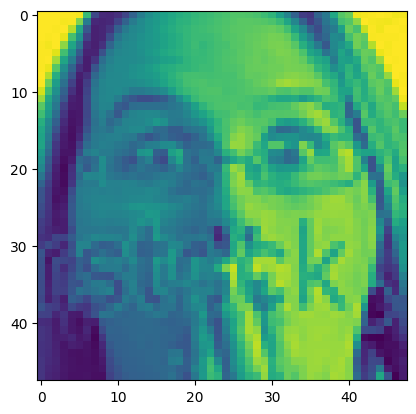

In [5]:
im = test_images[12]
plt.imshow(im)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


224


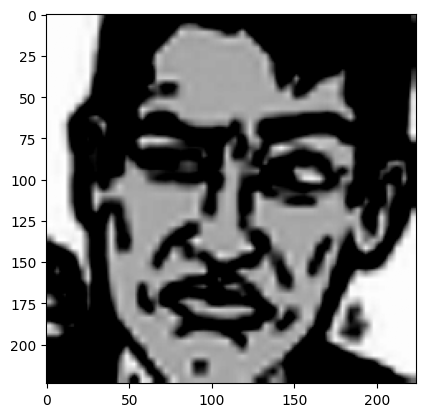

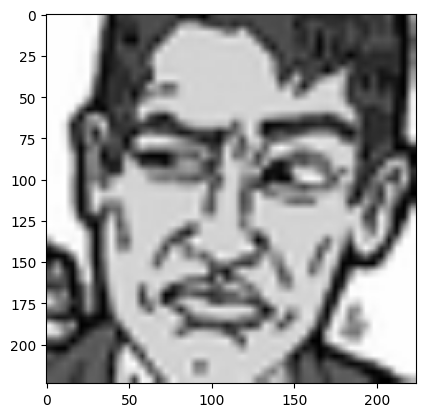

In [6]:
image, vanilla_image, label = dataset[0]

print(vanilla_image.width)

plt.imshow(image.permute(1, 2, 0))
plt.show()

plt.imshow(vanilla_image)
plt.show()

### Model

In [7]:
class Args:
    pass

args = Args()
args.vit_config = "ViT-B_16"
args.frozen_weights_flag = False
args.frozen_weights = ""
if(args.frozen_weights_flag):
    args.frozen_weights = "weights_frozen"
else:
    args.frozen_weights = "weights_not_frozen"
args.num_classes = 8
args.batch_size = 32
args.resolution = 224

In [8]:
config = CONFIGS[args.vit_config]
model = VisionTransformer(config, num_classes=args.num_classes, zero_head=True, img_size=args.resolution, vis=True)
model.load_from(np.load("C:\\BME\\7_felev\\szakdoli\\code\\ViT-pytorch\\attention_data\\ViT-B_16-224.npz"))
model.eval()
model_name = f"{args.vit_config}_{args.resolution}x{args.resolution}_b{args.batch_size}_{args.frozen_weights}_dataaug"

In [9]:
criterion = torch.nn.CrossEntropyLoss()

if args.frozen_weights_flag:
    print("frozen weights")
    optimizer = optim.Adam(model.head.parameters(), lr = 5e-4)

    for param in model.parameters():
        param.requires_grad = False
        
    for param in model.head.parameters():
        param.requires_grad = True
else:
    print("not frozen weights")
    optimizer = optim.Adam(model.parameters(), lr = 2e-4)

    for param in model.parameters():
        param.requires_grad = True
        
    for param in model.head.parameters():
        param.requires_grad = True

not frozen weights


In [10]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

GPU: NVIDIA GeForce RTX 3060 Laptop GPU is available.


In [11]:
model_dir="C:\\BME\\7_felev\\szakdoli\\models\\model_checkpoints_ferp"
model_name = "ViT-B_16_224x224_b32_weights_not_frozen_dataaug"

model_path = f"{model_dir}\\{model_name}.pth"

model = torch.load(model_path)

### MediaPipe detection

In [12]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

model_path_local = 'C:\\BME\\7_felev\\szakdoli\\models\\mediapipe\\face_landmarker_v2_with_blendshapes.task'

base_options = python.BaseOptions(model_asset_path=model_path_local)
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                        output_face_blendshapes=True,
                                        output_facial_transformation_matrixes=True,
                                        num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

In [13]:
# normalizer code from mediapipe

from typing import List, Mapping, Optional, Tuple, Union
import math

def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> Union[None, Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px

In [14]:
def get_detection_result_for_image(image, detector):
    image = np.array(image, dtype=np.uint8)
    
    image = mp.Image(image_format = mp.ImageFormat.SRGB, data = image)
    detection_result = detector.detect(image)
    
    return detection_result

### Transzformacios erteket - sajat modszer

In [15]:
def calculate_transformation_values_for_image(detection_result, image_width, image_height):
    nose_3d = detection_result.face_landmarks[0][4]
    forehead_3d = detection_result.face_landmarks[0][151]
    
    nose = _normalized_to_pixel_coordinates(nose_3d.x, nose_3d.y, image_width, image_height)
    forehead = _normalized_to_pixel_coordinates(forehead_3d.x, forehead_3d.y, image_width, image_height)
    if nose != None and forehead != None:
        nose_x, nose_y = nose
        forehead_x, forehead_y = forehead
        nose_2d = np.array([nose_x, nose_y])
        forehead_2d = np.array([forehead_x, forehead_y])
        center = np.array([int(image_height / 2), int(image_width / 2)])
        
        translation = center - nose_2d
        
        rotation_multiplier = -1
        if (forehead_2d - nose_2d)[0] > 0: rotation_multiplier = 1
        
        distance_nose_forehead = np.linalg.norm(nose_2d - forehead_2d)
        translated_forehead_2d = forehead_2d + translation
        rotated_forehead_2d = center + np.array([0, -distance_nose_forehead])
        
        scaling_factor = 90 / distance_nose_forehead
        
        b = np.linalg.norm(translated_forehead_2d - rotated_forehead_2d) / 2
        c = distance_nose_forehead
        
        rotation_angle = math.degrees(2 * math.asin(b / c))
        
        return translation, rotation_angle * rotation_multiplier, scaling_factor
    else:
        return None
    

### Transzformacios ertekek - cv2 segitsegevel

In [16]:
def convert_3d_2_2d(face_landmarks, image_width, image_height):
    _2d_coords = []
    for landmark in face_landmarks:
        px_coords = _normalized_to_pixel_coordinates(landmark.x, landmark.y, image_width, image_height)
        
        if px_coords != None:
            x, y = px_coords
            _2d_coords.append([x, y])
        else:
            _2d_coords.append([0, 0])
            
    return np.array(_2d_coords)

In [17]:
def calculate_transformation_values_for_image_cv2(detection_result, image_width, image_height, average_mesh):
    face_mesh = convert_3d_2_2d(detection_result.face_landmarks[0], image_width, image_height)

    src_points = face_mesh
    dst_points = average_mesh
    
    matrix, inliers = cv2.estimateAffine2D(src_points, dst_points)
    print(f"matrixxx 2: {matrix}")
    
    #calc = src_points @ matrix[:, :2].T + matrix[:, 2]
    
    # plt.hist(((src_points @ matrix[:, :2].T + matrix[:, 2]) - dst_points))
    # plt.scatter(*(src_points @ matrix[:, :2].T + matrix[:, 2]).T)
    # plt.scatter(*dst_points.T)
    # plt.show()
    
    translation_x = matrix[0, 2]
    translation_y = matrix[1, 2]
    
    a, b = matrix[0, 0], matrix[0, 1]
    c, d = matrix[1, 0], matrix[1, 1]

    scale_x = np.sqrt(a**2 + b**2)
    scale_y = np.sqrt(c**2 + d**2)

    rotation_angle = np.degrees(np.arctan2(b, a))
    
    return [translation_x, translation_y], rotation_angle, scale_x, matrix

### Transzformacios ertekek - jo modszer

In [18]:
def calculate_transformation_matrix(detection_result, image_width, image_height, average_mesh):
    face_mesh = convert_3d_2_2d(detection_result.face_landmarks[0], image_width, image_height)

    src_points = face_mesh
    dst_points = average_mesh
    
    matrix, inliers = cv2.estimateAffine2D(src_points, dst_points)
    
    # plt.scatter(*(src_points @ matrix[:, :2].T + matrix[:, 2]).T)
    # plt.scatter(*dst_points.T)
    # plt.show()
    
    return matrix

### Transzformacios fuggvenyek

In [19]:
def translate_image(image, translation):
    translation_matrix = np.float32([[1, 0, translation[0]], [0, 1, translation[1]]])
    translated_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    return translated_image

In [ ]:
def rotate_image(image, center, angle):
    center = (int(center[1]), int(center[0]))
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))
    return rotated_image

In [21]:
def zoom_image(image, zoom_factor, dim = 3, target_size=(224, 224)):
    center_x, center_y = image.shape[1] // 2, image.shape[0] // 2

    if zoom_factor > 1:
        crop_width = int(image.shape[1] / zoom_factor)
        crop_height = int(image.shape[0] / zoom_factor)

        x1 = center_x - crop_width // 2
        x2 = center_x + crop_width // 2
        y1 = center_y - crop_height // 2
        y2 = center_y + crop_height // 2

        x1, x2 = max(0, x1), min(image.shape[1], x2)
        y1, y2 = max(0, y1), min(image.shape[0], y2)

        cropped_image = image[y1:y2, x1:x2]

        zoomed_image = cv2.resize(cropped_image, target_size, interpolation=cv2.INTER_LINEAR)
    elif zoom_factor == 1:
        zoomed_image = image
    else:
        new_width = int(image.shape[1] / zoom_factor)
        new_height = int(image.shape[0] / zoom_factor)

        padded_image = np.zeros((new_height, new_width, dim), dtype=image.dtype)

        start_x = (new_width - image.shape[1]) // 2
        start_y = (new_height - image.shape[0]) // 2

        padded_image[start_y:start_y + image.shape[0], start_x:start_x + image.shape[1]] = image

        zoomed_image = cv2.resize(padded_image, (target_size[1], target_size[0]))

        
    return zoomed_image


### Attention map megszerzese

In [22]:
# calculating attention mask based on a given attention matrix
def get_attention_mask(att_mat, size):
    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)
    att_mat = att_mat.to('cpu')
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
        
    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), size)[..., np.newaxis]
    
    return mask

### Fuggvenyek kiertekelese egy peldara

#### Attention map megszerzese es plottolasa peldakepre

In [32]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral', 7: 'Contempt'}

In [33]:
def get_emotion_for_prediction(pred):
    emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral', 7: 'Contempt'}
    max_index = torch.argmax(pred)
    return emotions[max_index.item()]

In [ ]:
i = 316

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: Happy
Predictions: Happy
0.34875205
0.9840909


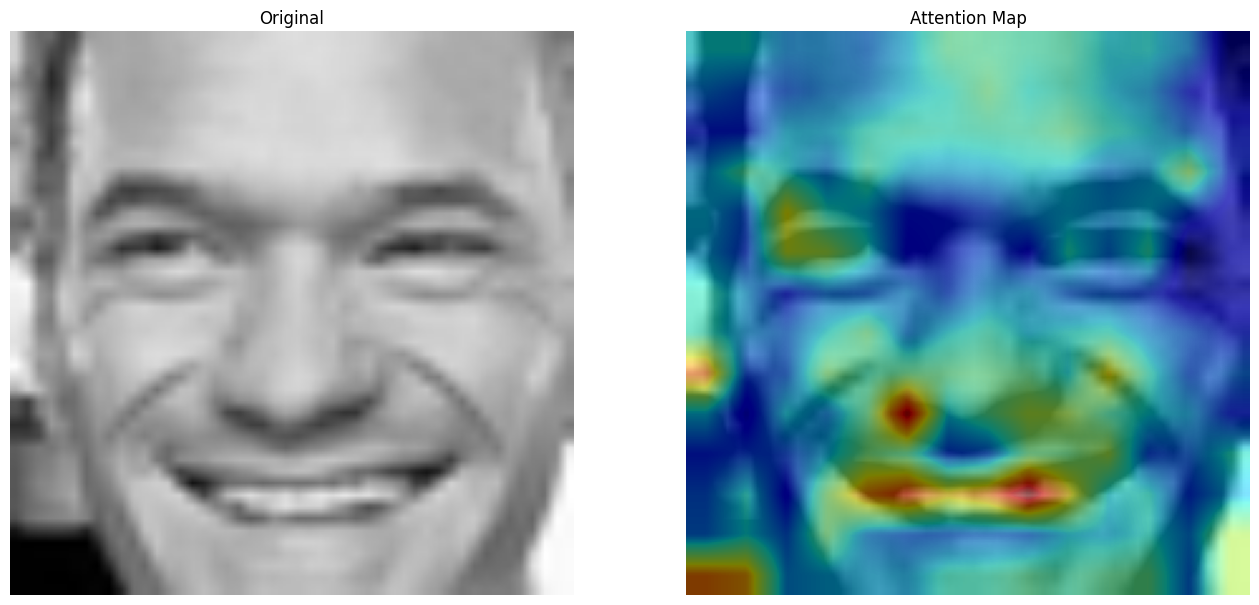

In [ ]:
model.eval()
model.to(device)

face_image, face_image_vanilla, label = dataset[i]

gt = emotions[int(torch.argmax(label))]

face_image = face_image.to(device)
label = label.to(device)

output, att_map = model(face_image.unsqueeze(0))
mask = get_attention_mask(att_map, (face_image.shape[1], face_image.shape[2]))

face_image = face_image.to('cpu')

label = torch.argmax(label)
pred = get_emotion_for_prediction(output)

print(f"Label: {gt}")
print(f"Predictions: {pred}")

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

vmin = mask.min()
vmax = mask.max()

print(vmin)
print(vmax)

ax1.set_title('Original')
ax2.set_title('Attention Map')
ax1.axis('off')
ax2.axis('off')
_ = ax1.imshow(face_image_vanilla)
_ = ax2.imshow(face_image.permute(1, 2, 0))
_ = ax2.imshow(mask, cmap='jet', alpha=0.5)

#### Trafo ertekek megszerzese

In [113]:
detection_result = get_detection_result_for_image(face_image_vanilla, detector)

data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data"
average_mesh = np.load(os.path.join(data_src_folder, "average_mask.npy"))
average_mesh = np.rint(average_mesh).astype(int)

t_cv2, r_cv2, s_cv2, matrix = calculate_transformation_values_for_image_cv2(detection_result, 224, 224, average_mesh)
transformation_matrix = calculate_transformation_matrix(detection_result, 224, 224, average_mesh)

matrixxx 2: [[  0.84548168  -0.05732196  19.99269925]
 [  0.0376656    0.98987528 -23.13164918]]


###### deprecated code

In [28]:
# THESE VALUES - T(RANSLATION), R(OTATION), S(CALE_VALUE) ARE RETRIEVED BY RUNNING ONE OF THE FUNCTIONS ABOVE THAT CALCULATE TRANSFORMATION VALUES FOR A GIVEN IMAGE

# face_image_np = np.array(face_image.permute(1, 2, 0))
# translated_image = translate_image(face_image_np, t)

# center = np.array([int(face_image_np.shape[0] / 2), int(face_image_np.shape[1] / 2)])
# rotated_image = rotate_image(translated_image, center, r)

# final_image = zoom_image(rotated_image, s)

# translated_mask = translate_image(mask, t)

# center = np.array([int(mask.shape[0] / 2), int(mask.shape[1] / 2)])
# rotated_mask = rotate_image(translated_mask, center, r)
# rotated_mask = rotated_mask[:, :, np.newaxis]

# final_mask = zoom_image(rotated_mask, s, 1)
# print(final_mask.shape)

#### Transzformalas es plottolas

In [114]:
final_image = cv2.warpAffine(np.array(face_image.permute(1, 2, 0)), transformation_matrix, (224, 224))
final_mask = cv2.warpAffine(mask, transformation_matrix, (224, 224))
final_image = (final_image - final_image.min()) / (final_image.max() - final_image.min())

print(final_mask.min())
print(final_mask.max())

0.0
0.9807299


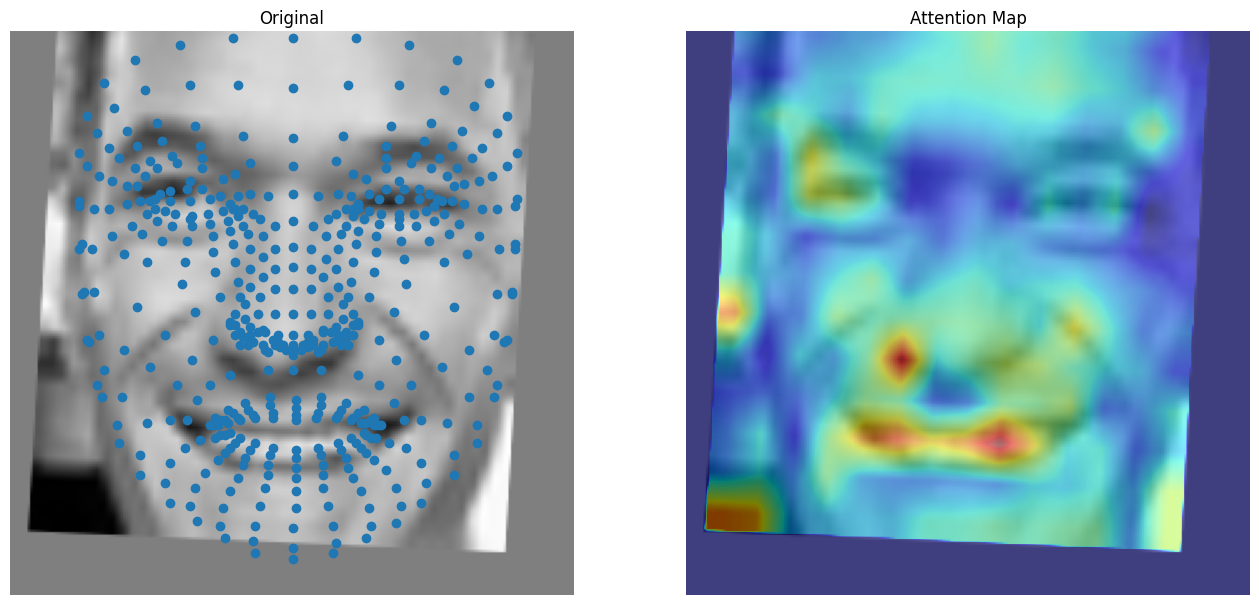

In [117]:
vmin_image = final_image.min()
vmax_image = final_image.max()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(final_image, vmin=vmin_image, vmax=vmax_image)
_ = ax1.scatter(*average_mesh.T)
_ = ax2.imshow(final_image)
_ = ax2.imshow(final_mask, cmap='jet', alpha=0.5, vmin=vmin, vmax=vmax)

#### Average attention map-ek eloallitasa

In [126]:
def average_masks(masks):
    masks_sum = np.zeros((masks.shape[1], masks.shape[2], masks.shape[3]))
    for i in range(masks.shape[0]):
        masks_sum += masks[i]
        
    masks_avg = masks_sum / masks.shape[0]
    
    return masks_avg

In [127]:
def average_masks_no_zeros(masks):
    masks_sum = np.zeros((masks.shape[1], masks.shape[2], masks.shape[3]))
    
    non_zero_count = np.zeros((masks.shape[1], masks.shape[2], masks.shape[3]))
    
    for i in range(masks.shape[0]):
        mask = masks[i]
        
        masks_sum += mask
        
        non_zero_count += (mask > 0).astype(np.float32)
    
    non_zero_count[non_zero_count == 0] = 1
    
    masks_avg = masks_sum / non_zero_count
    
    return masks_avg

In [31]:
def transform_mask(mask, translation, rotation, scale):
    flag = False
    if scale < 1: flag = True
    translated_mask = translate_image(mask, translation)

    center = np.array([int(mask.shape[0] / 2), int(mask.shape[1] / 2)])
    rotated_mask = rotate_image(translated_mask, center, rotation)
    if flag: rotated_mask = rotated_mask[:, :, np.newaxis]
    
    final_mask = zoom_image(rotated_mask, scale, 1)
    final_mask = final_mask[:, :, np.newaxis]
    
    return final_mask

In [31]:
def get_attention_masks_for_classes(dataset):
    data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data"
    average_mesh = np.load(os.path.join(data_src_folder, "average_mask.npy"))
    num_classes = 8
    masks = [[] for _ in range(num_classes)]
    indices = [[] for _ in range(num_classes)]
    
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        for i in range(len(dataset)):
            
            if i % 500 == 0:
                print(i)
            
            image, vanilla_image, label = dataset[i]
            
            image = image.to(device)
            label = label.to(device)
            
            output, att_mat = model(image.unsqueeze(0))
            
            label_max = torch.argmax(label)
            output_max = torch.argmax(output)
            # if model prediction is correct
            if(label_max == output_max):
                mask = get_attention_mask(att_mat, (image.shape[1], image.shape[2]))
                detection_result = get_detection_result_for_image(vanilla_image, detector)
                transformation_matrix = calculate_transformation_matrix(detection_result, vanilla_image.width, vanilla_image.height, average_mesh)
                transformed_mask = cv2.warpAffine(mask, transformation_matrix, (vanilla_image.width, vanilla_image.height))
                transformed_mask = np.expand_dims(transformed_mask, axis=-1)
                
                masks[label_max].append(transformed_mask)
                indices[label_max].append(i)
    
    
    return masks, indices

In [32]:
masks, indices = get_attention_masks_for_classes(dataset)

0


KeyboardInterrupt: 

In [48]:
angry_masks = np.array(masks[0])
disgust_masks = np.array(masks[1])
fear_masks = np.array(masks[2])
happy_masks = np.array(masks[3])
sad_masks = np.array(masks[4])
surprise_masks = np.array(masks[5])
neutral_masks = np.array(masks[6])
contempt_masks = np.array(masks[7])

angry_indices = np.array(indices[0])
disgust_indices = np.array(indices[1])
fear_indices = np.array(indices[2])
happy_indices = np.array(indices[3])
sad_indices = np.array(indices[4])
surprise_indices = np.array(indices[5])
neutral_indices = np.array(indices[6])
contempt_indices = np.array(indices[7])

In [49]:
data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data\\averaged_masks_matrix_calculation"

np.save(os.path.join(data_src_folder, "angry_masks_224.npy"), angry_masks)
np.save(os.path.join(data_src_folder, "disgust_masks_224.npy"), disgust_masks)
np.save(os.path.join(data_src_folder, "fear_masks_224.npy"), fear_masks)
np.save(os.path.join(data_src_folder, "happy_masks_224.npy"), happy_masks)
np.save(os.path.join(data_src_folder, "sad_masks_224.npy"), sad_masks)
np.save(os.path.join(data_src_folder, "surprise_masks_224.npy"), surprise_masks)
np.save(os.path.join(data_src_folder, "neutral_masks_224.npy"), neutral_masks)
np.save(os.path.join(data_src_folder, "contempt_masks_224.npy"), contempt_masks)


np.save(os.path.join(data_src_folder, "angry_indices.npy"), angry_indices)
np.save(os.path.join(data_src_folder, "disgust_indices.npy"), disgust_indices)
np.save(os.path.join(data_src_folder, "fear_indices.npy"), fear_indices)
np.save(os.path.join(data_src_folder, "happy_indices.npy"), happy_indices)
np.save(os.path.join(data_src_folder, "sad_indices.npy"), sad_indices)
np.save(os.path.join(data_src_folder, "surprise_indices.npy"), surprise_indices)
np.save(os.path.join(data_src_folder, "neutral_indices.npy"), neutral_indices)
np.save(os.path.join(data_src_folder, "contempt_indices.npy"), contempt_indices)

### Load data and plot averaged masks

In [142]:
#data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data\\averaged_masks_am_cv2_notpartialaffine_transformed"
#data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data\\averaged_masks_am_cv2_transformed"
#data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data\\averaged_masks_am_self_transformed"
#data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data\\averaged_masks_pm"
#data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data\\averaged_masks_pm_matrix"
data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data\\averaged_masks_matrix_calculation"

angry_masks = np.load(os.path.join(data_src_folder, "angry_masks_224.npy"))
disgust_masks = np.load(os.path.join(data_src_folder, "disgust_masks_224.npy"))
fear_masks = np.load(os.path.join(data_src_folder, "fear_masks_224.npy"))
happy_masks = np.load(os.path.join(data_src_folder, "happy_masks_224.npy"))
sad_masks = np.load(os.path.join(data_src_folder, "sad_masks_224.npy"))
surprise_masks = np.load(os.path.join(data_src_folder, "surprise_masks_224.npy"))
neutral_masks = np.load(os.path.join(data_src_folder, "neutral_masks_224.npy"))
contempt_masks = np.load(os.path.join(data_src_folder, "contempt_masks_224.npy"))

angry_indices = np.load(os.path.join(data_src_folder, "angry_indices.npy"))
disgust_indices = np.load(os.path.join(data_src_folder, "disgust_indices.npy"))
fear_indices = np.load(os.path.join(data_src_folder, "fear_indices.npy"))
happy_indices = np.load(os.path.join(data_src_folder, "happy_indices.npy"))
sad_indices = np.load(os.path.join(data_src_folder, "sad_indices.npy"))
surprise_indices = np.load(os.path.join(data_src_folder, "surprise_indices.npy"))
neutral_indices = np.load(os.path.join(data_src_folder, "neutral_indices.npy"))
contempt_indices = np.load(os.path.join(data_src_folder, "contempt_indices.npy"))

### Checking patch embedding related information

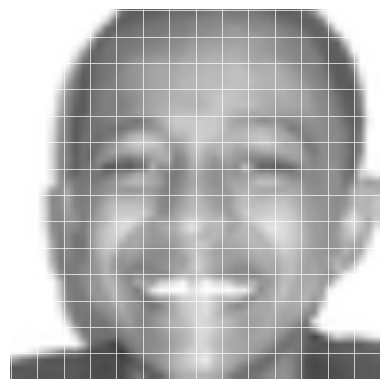

In [24]:
face_image, face_image_vanilla, label = dataset[76]

plt.imshow(face_image_vanilla)

height, width = 224, 224

cell_size = 16
num_cells = 14

for x in range(0, width, cell_size):
    plt.axvline(x, color='white', linestyle='-', linewidth=0.5)

for y in range(0, height, cell_size):
    plt.axhline(y, color='white', linestyle='-', linewidth=0.5)

plt.axis('off')
plt.show()

### Checking if calculated maps are correct

In [25]:
mask_index = 777

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

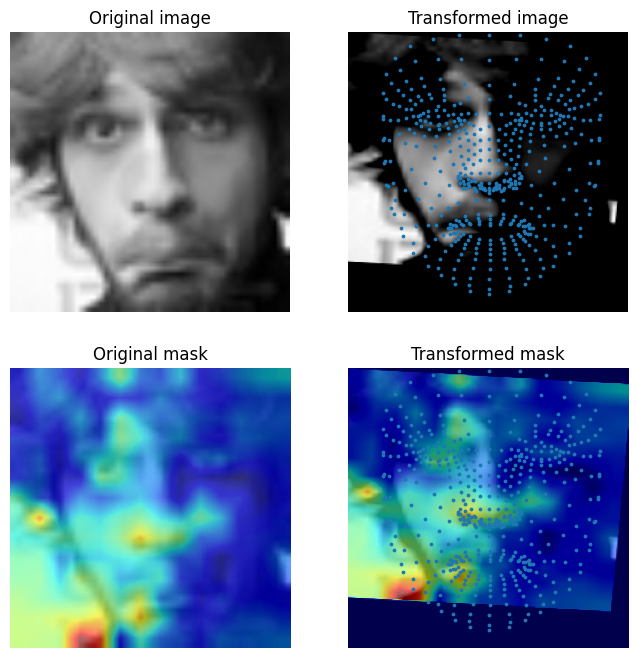

In [26]:
model.eval()
model.to(device)


traf_mask = neutral_masks[mask_index]
index = neutral_indices[mask_index]

face_image, face_image_vanilla, label = dataset[index]

detection_result = get_detection_result_for_image(face_image_vanilla, detector)
data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data"
average_mesh = np.load(os.path.join(data_src_folder, "average_mask.npy"))
average_mesh = np.rint(average_mesh).astype(int)
transformation_matrix = calculate_transformation_matrix(detection_result, 224, 224, average_mesh)
transformed_image = cv2.warpAffine(np.array(face_image.permute(1, 2, 0)), transformation_matrix, (224, 224))

face_image = face_image.to(device)
label = label.to(device)

output, att_mat = model(face_image.unsqueeze(0))
mask = get_attention_mask(att_mat, (face_image.shape[1], face_image.shape[2]))

face_image.to('cpu')
label.to('cpu')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

vmin = mask.min()
vmax = mask.max()

ax1.set_title('Original image')
ax2.set_title('Transformed image')
ax3.set_title('Original mask')
ax4.set_title('Transformed mask')
_ = ax1.imshow(face_image_vanilla)
_ = ax2.imshow(transformed_image)
_ = ax2.scatter(*average_mesh.T, s = 3)
_ = ax3.imshow(face_image_vanilla)
_ = ax3.imshow(mask, cmap='jet', alpha=0.6)
_ = ax4.imshow(transformed_image)
_ = ax4.imshow(traf_mask, cmap='jet', vmin=vmin, vmax=vmax, alpha=0.6)
_ = ax4.scatter(*average_mesh.T, s = 3)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

### Attention rollout - visualizing attention maps for each layer

In [28]:
i = 1555

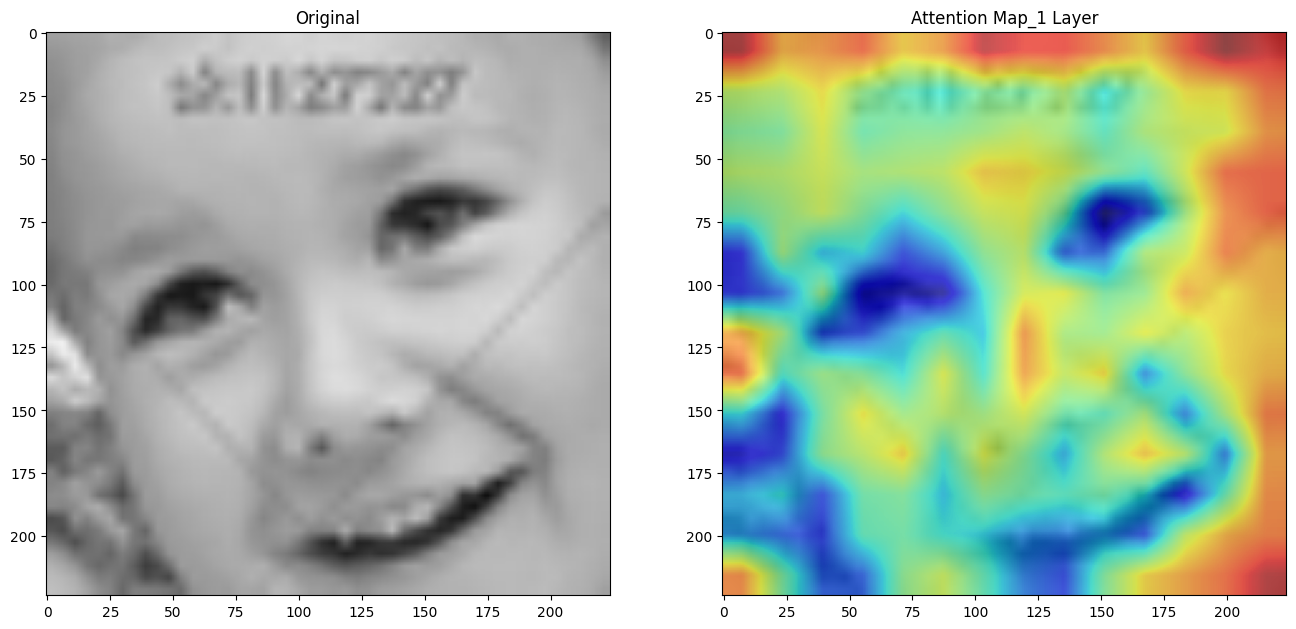

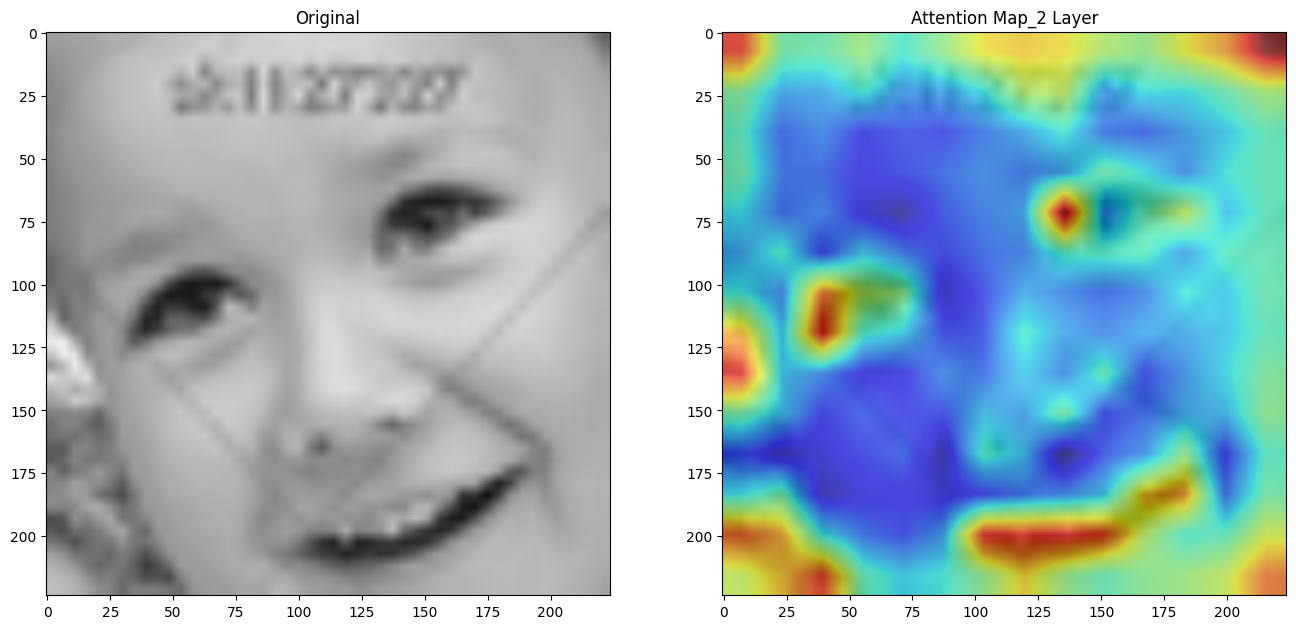

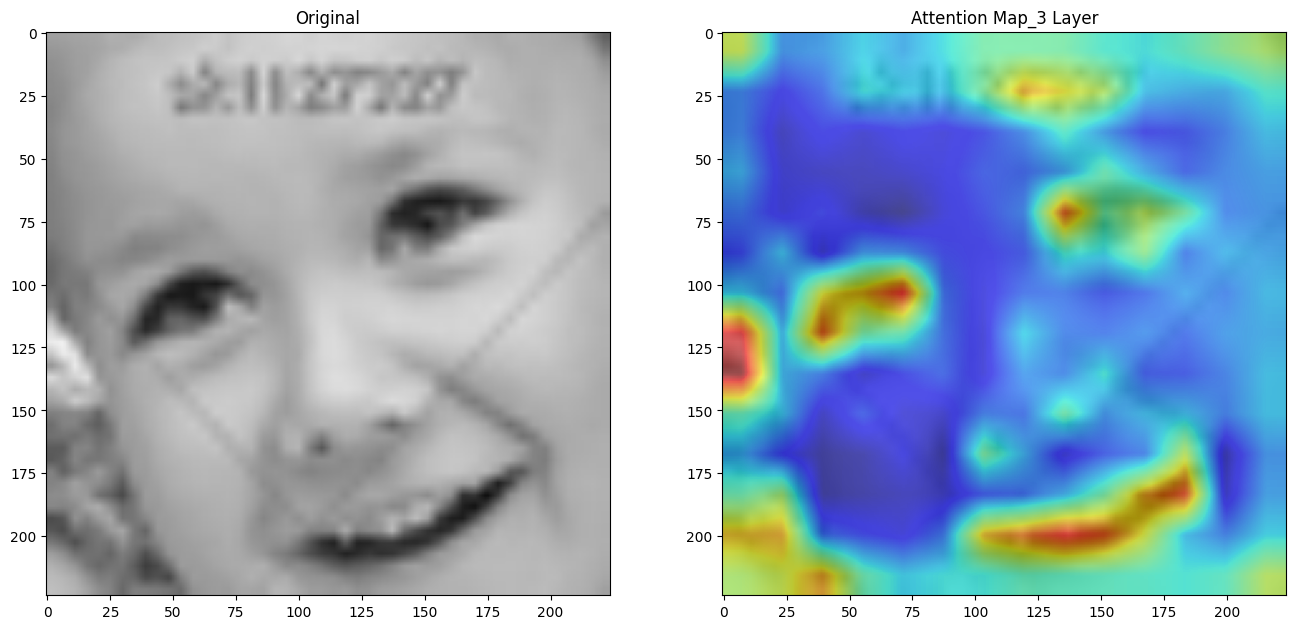

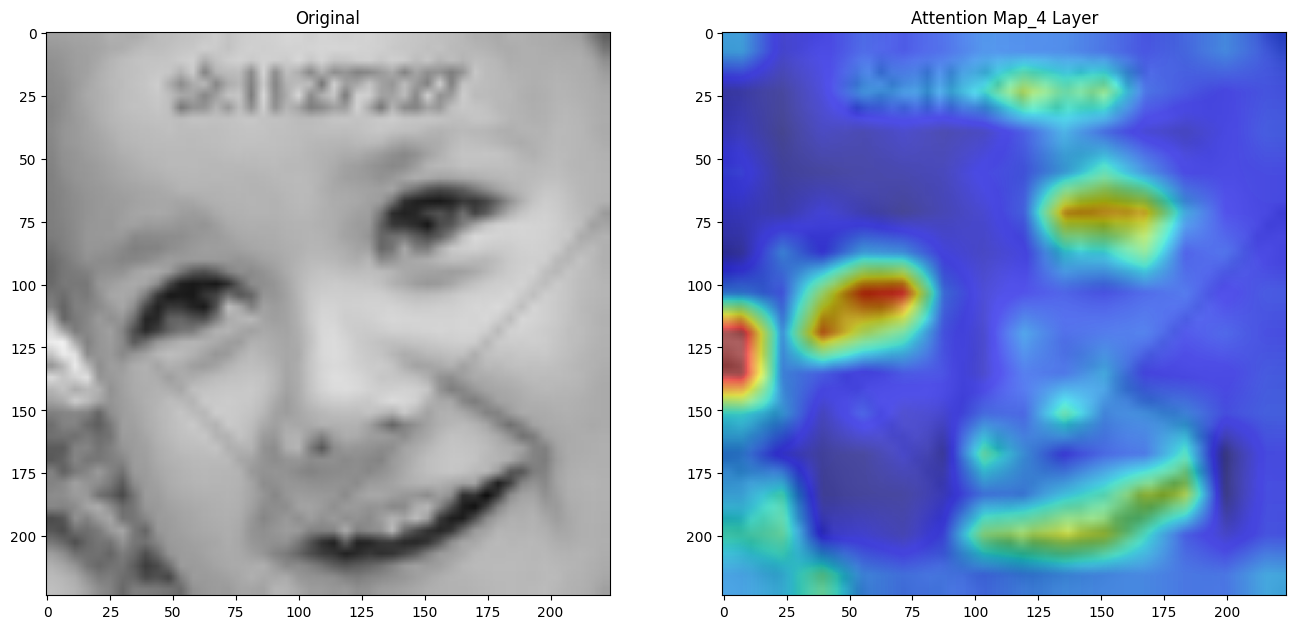

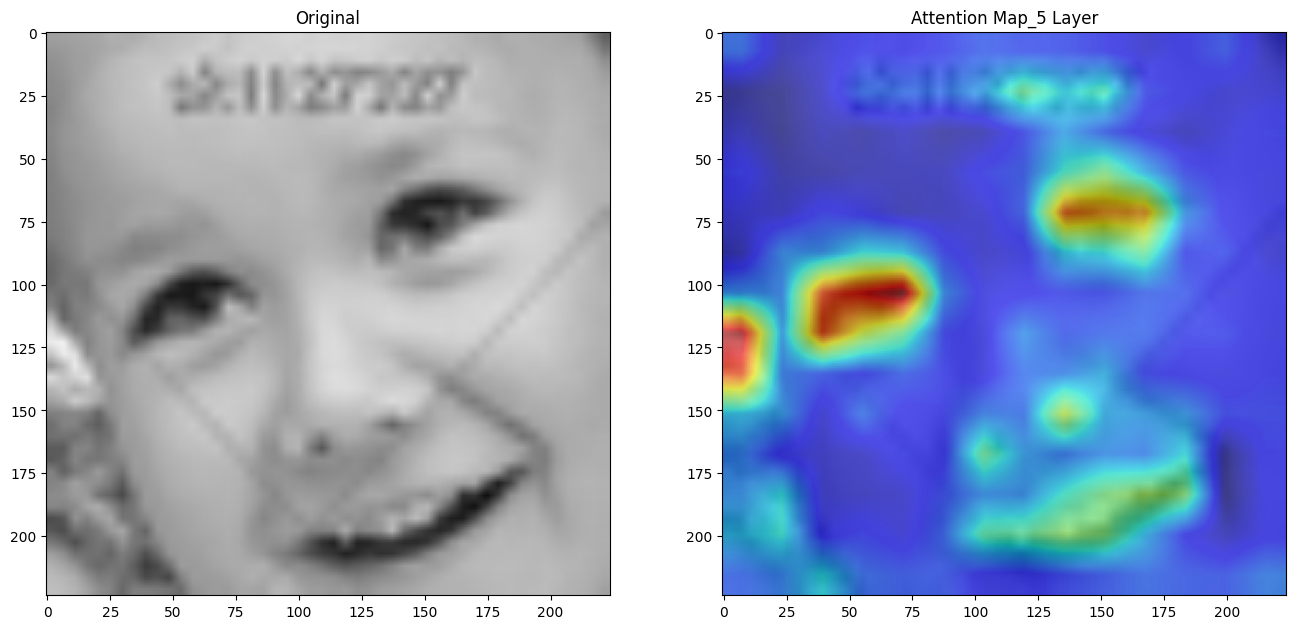

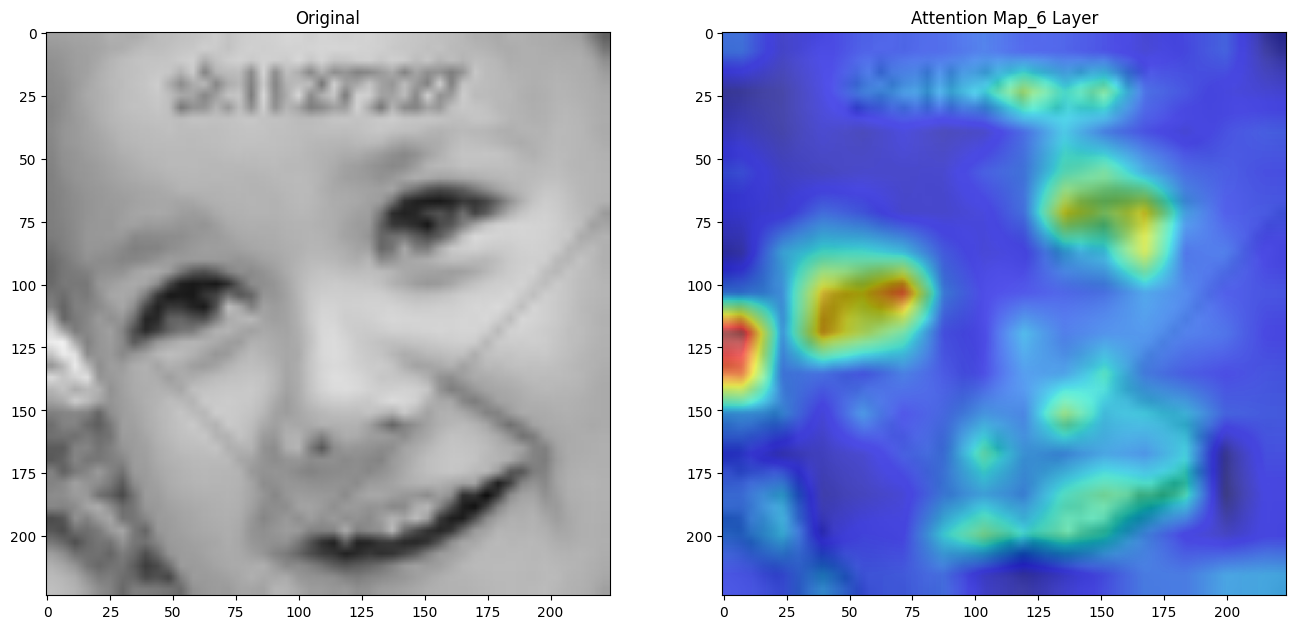

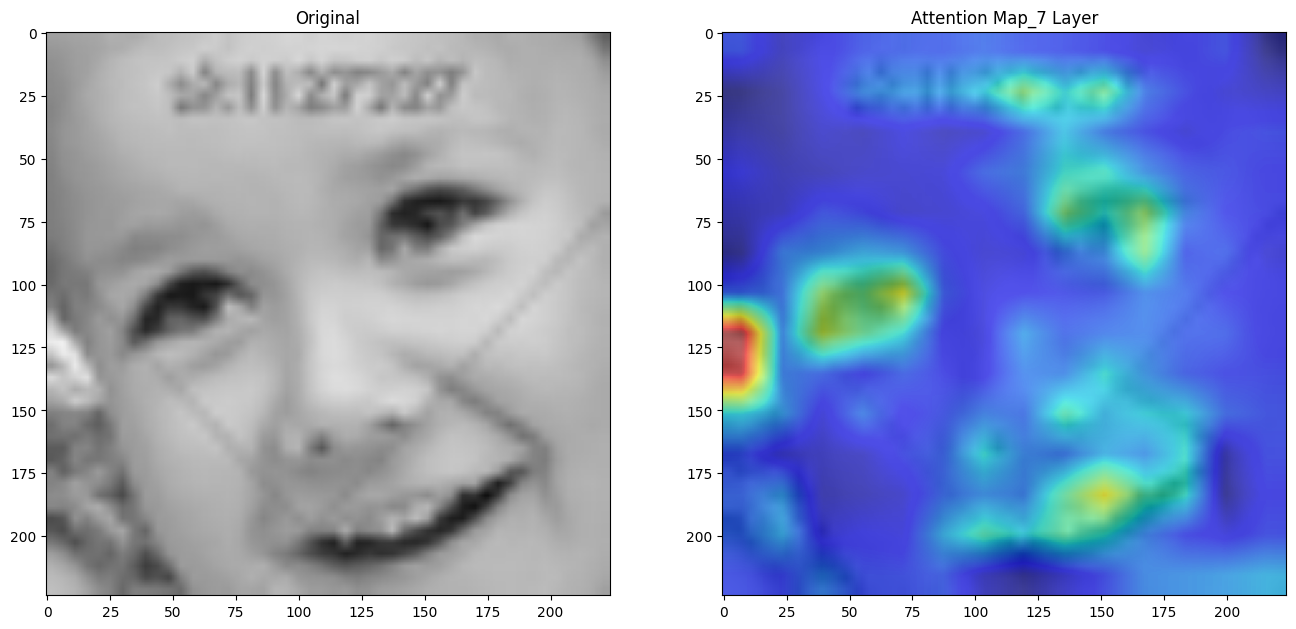

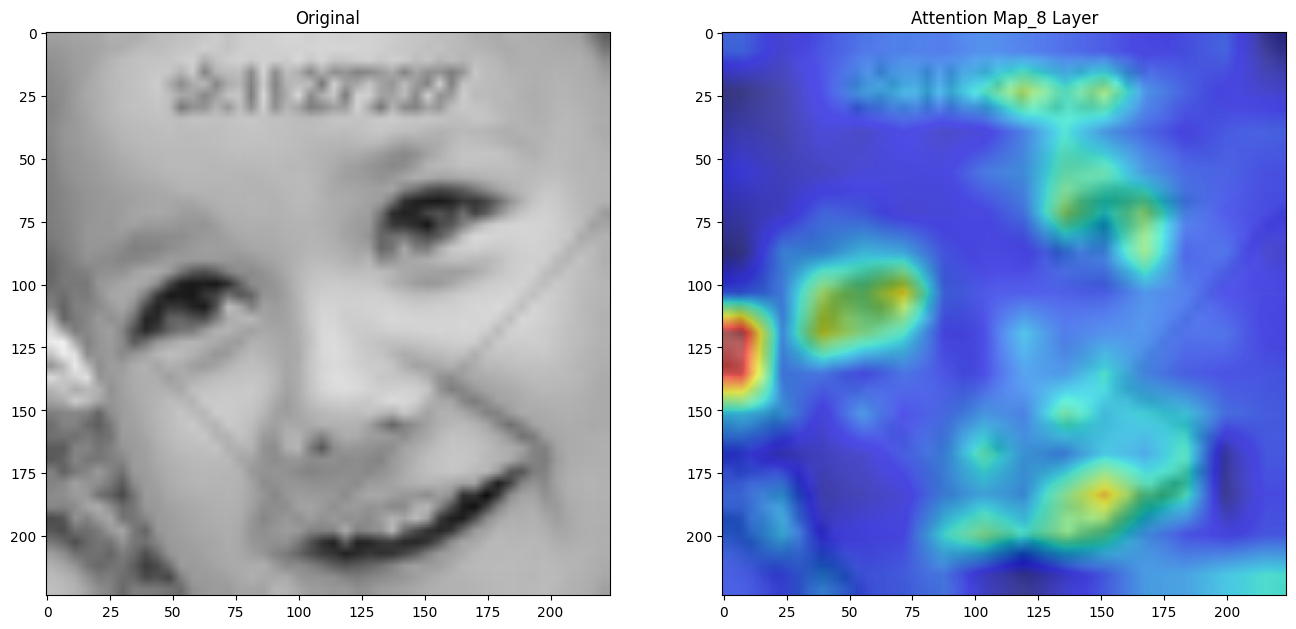

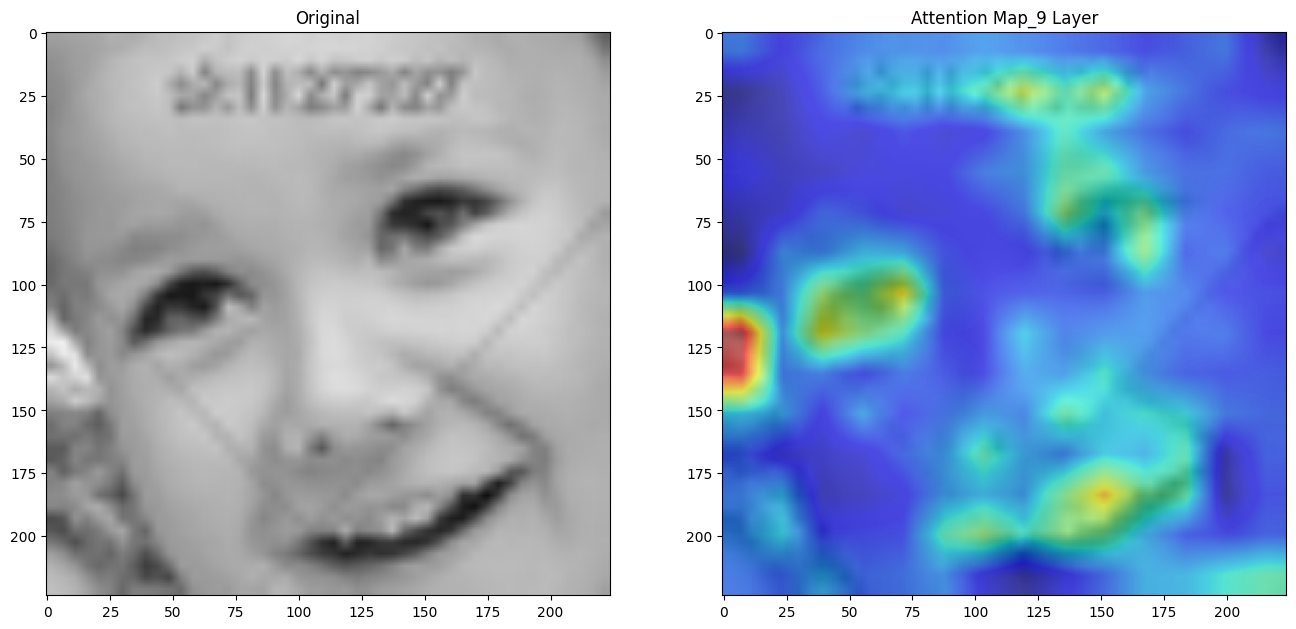

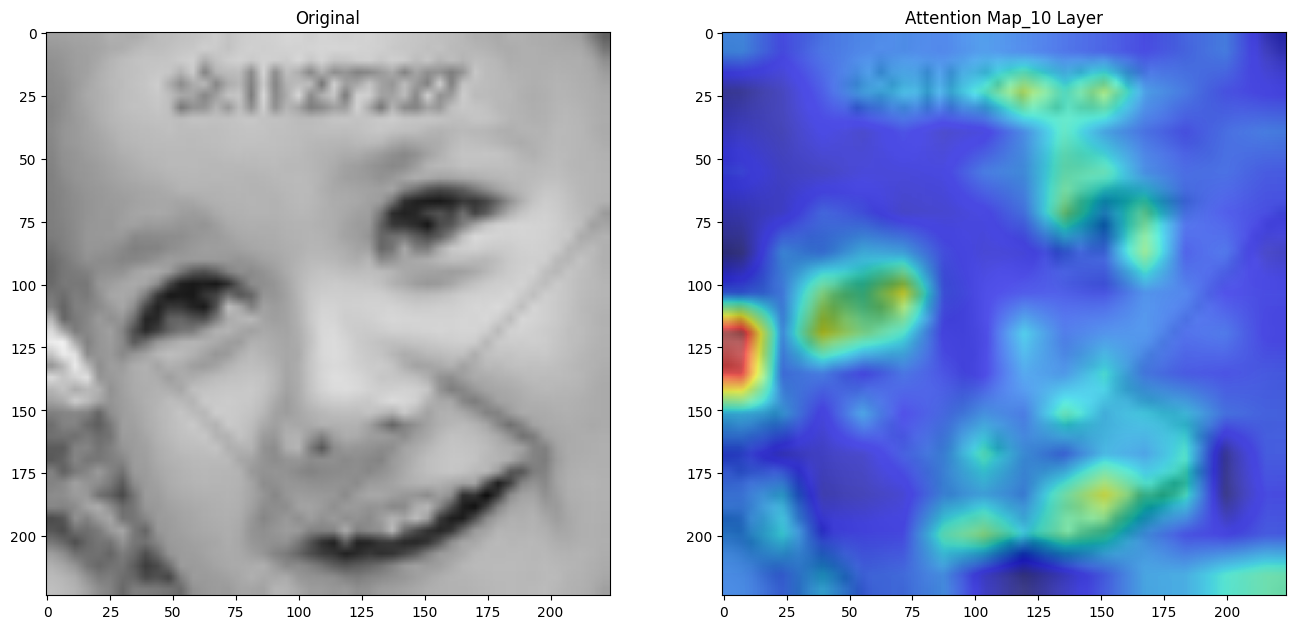

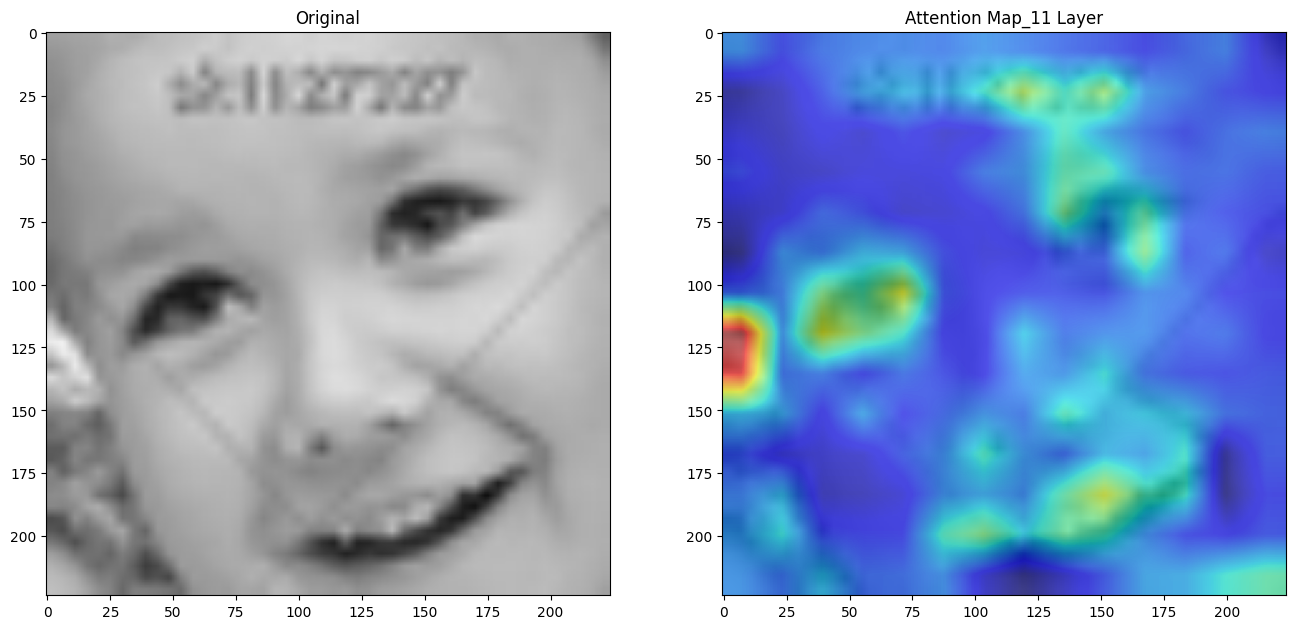

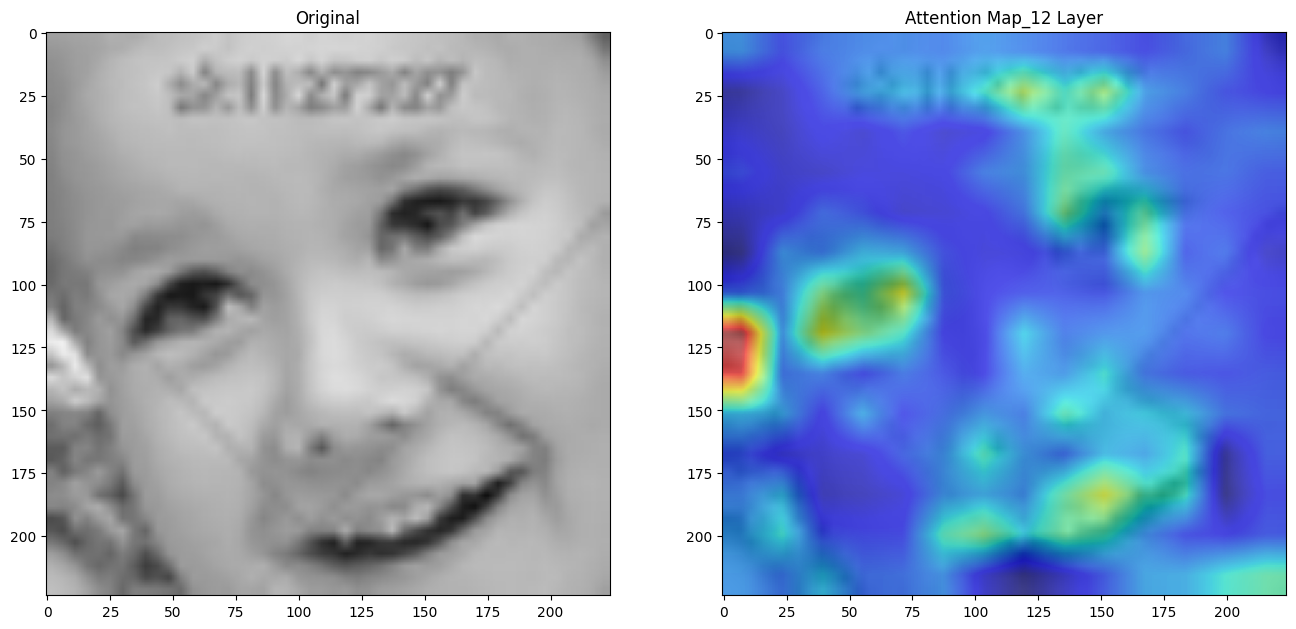

In [29]:
model.to('cpu')
size = (224, 224)

face_image, face_image_vanilla, label = dataset[i]

logits, att_mat = model(face_image.unsqueeze(0))

att_mat = torch.stack(att_mat).squeeze(1)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)
att_mat = att_mat.to('cpu')
# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
        
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), size)[..., np.newaxis]

for i, v in enumerate(joint_attentions):
    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), size)[..., np.newaxis]
    result = (mask * face_image_vanilla).astype("uint8")

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map_%d Layer' % (i+1))
    _ = ax1.imshow(face_image_vanilla)
    _ = ax2.imshow(face_image_vanilla)
    _ = ax2.imshow(mask, cmap='jet', alpha=0.6)

### Rest of the plotting

(224, 224, 1)
[0.48281664]
0.0
0.8582919


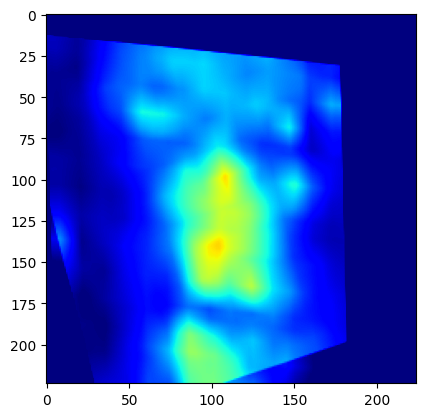

In [143]:
print(angry_masks[0].shape)
print(angry_masks[0][0][0])

print(((angry_masks[200] + angry_masks[201]) / 2).min())
print(((angry_masks[200] + angry_masks[201]) / 2).max())

plt.imshow(((angry_masks[200] + angry_masks[201] + angry_masks[202]) / 3), cmap='jet', alpha=1, vmin=0.31007323, vmax=0.979999)
plt.show()

In [144]:
print("Angry masks length:", len(angry_masks))
print("Disgust masks length:", len(disgust_masks))
print("Fear masks length:", len(fear_masks))
print("Happy masks length:", len(happy_masks))
print("Sad masks length:", len(sad_masks))
print("Surprise masks length:", len(surprise_masks))
print("Neutral masks length:", len(neutral_masks))
print("Contempt masks length:", len(contempt_masks))

Angry masks length: 205
Disgust masks length: 16
Fear masks length: 46
Happy masks length: 805
Sad masks length: 229
Surprise masks length: 357
Neutral masks length: 886
Contempt masks length: 8


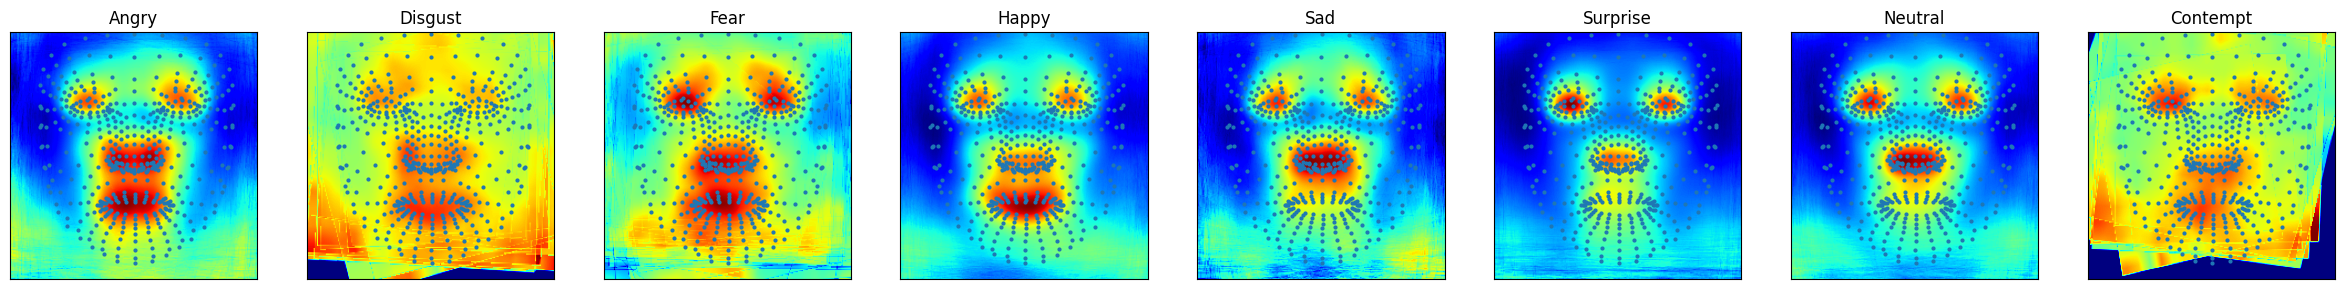

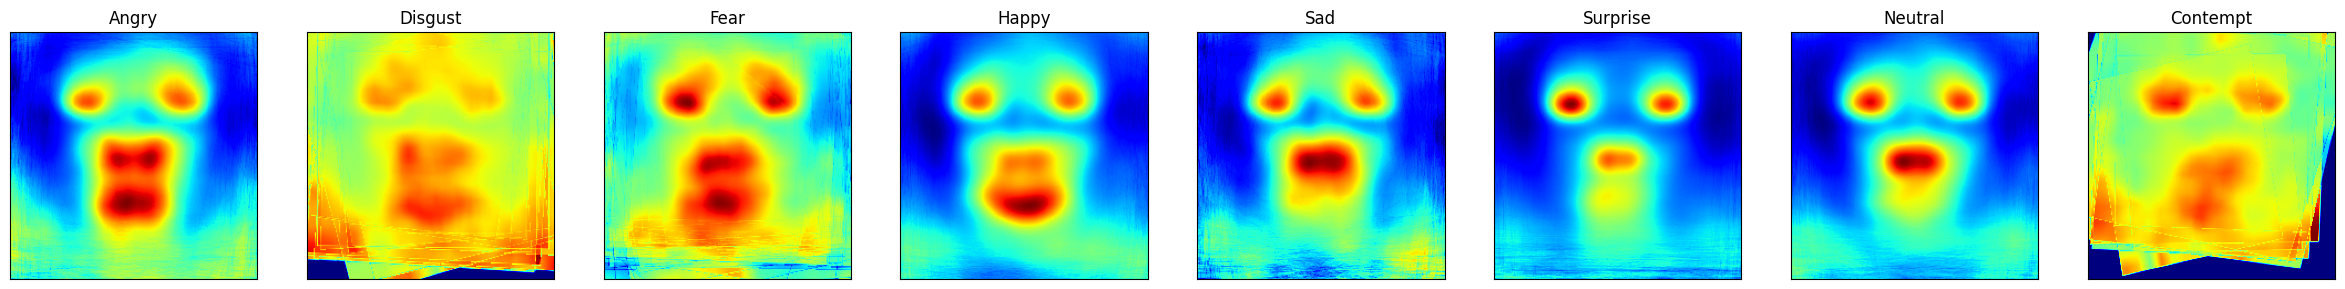

In [ ]:
mask_dict = {0: angry_masks, 1: disgust_masks, 2: fear_masks, 3: happy_masks, 4: sad_masks, 5: surprise_masks, 6: neutral_masks, 7: contempt_masks}
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral', 7: 'Contempt'}

min_dict = {
    0: 0.38070346040781156,
    1: 0.3424244685606523,
    2: 0.3453761512456938,
    3: 0.3831559259694084,
    4: 0.39589023117971894,
    5: 0.3647333800630725,
    6: 0.3825370031464947,
    7: 0.3345396876335144
}

max_dict = {
    0: 0.723511797051097,
    1: 0.7804302789948203,
    2: 0.7373064326685529,
    3: 0.7078340137200771,
    4: 0.7555393471871272,
    5: 0.7532899900461021,
    6: 0.7568685152817294,
    7: 0.8050371289253235
}

data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data"
average_mesh = np.load(os.path.join(data_src_folder, "average_mask.npy"))

def plot_all_mask_averages(display_average = False):
    fig, axs = plt.subplots(1, 8, figsize=(30, 12))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    axs = axs.ravel()
    for i in range(8):
        average_mask = average_masks_no_zeros(mask_dict[i])
        #average_mask = (average_mask - average_mask.min()) / (average_mask.max() - average_mask.min())
        axs[i].imshow(average_mask, cmap='jet')
        axs[i].set_title(emotions[i])
        if display_average: axs[i].scatter(*average_mesh.T, s = 4)
        axs[i].set_xticks([])
        axs[i].set_yticks([])

    plt.show()
    
plot_all_mask_averages(True)
plot_all_mask_averages()